<a href="https://colab.research.google.com/github/AndrewKrugTech/analyticspractice/blob/main/Dirty%20vs%20Cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import cv2
import time
import copy
import shutil 
import zipfile
from torchvision import transforms, models
from tqdm import tqdm

# **Classes and Functions** 

In [2]:
! pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download andrewkrug/plates
! unzip plates.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 96% 45.0M/47.1M [00:00<00:00, 116MB/s]
100% 47.1M/47.1M [00:00<00:00, 112MB/s]
Archive:  plates.zip
  inflating: plates/test/0000.jpg    
  inflating: plates/test/0001.jpg    
  inflating: plates/test/0002.jpg    
  inflating: plates/test/0003.jpg    
  inflating: plates/test/0004.jpg    
  inflating: plates/test/0005.jpg    
  inflating: plates/test/0006.jpg    
  inflating: plates/test/0007.jpg    
  inflating: plates/test/0008.jpg    
  inflating: plates/test/0009.jpg    
  inflating: plates/test/0010.jpg    
  inflating: plates/test/0011.jpg    
  inflating: plates/test/0012.jpg    
  inflating: plates/test/0013.jpg    
  inflating: plates/test/0014.jpg    
  inflating: plates/test/0015.jpg    
  inflating: plates/test/0016.jpg    
  inflating: plates/test/0017.jpg    
  inflating: plates/test/0018.jpg    
  inflating: plates/test/0019.jpg    
  inflating: plates/test/0020.jpg    
  

## Prepare some Classes and Functions for pictures transformations

In [3]:
class MyRemoveBackground:
    """Remove images background.
    """
    
    def __init__(self):
        pass

    def __call__(self, in_img):
        
        # Convert PIL image to numpy array
        in_img = np.array(in_img)
        
        # Get the height and width from OpenCV image
        height, width = in_img.shape[:2]
        
        # Create a mask holder
        mask = np.zeros([height, width], np.uint8)

        # Grab Cut the object
        bgdModel = np.zeros((1, 65),np.float64)
        fgdModel = np.zeros((1, 65),np.float64)

        # Hard Coding the Rect The object must lie within this rect.
        rect = (15, 15, width-30, height-30)
        cv2.grabCut(in_img, mask, rect, bgdModel, fgdModel, 10, cv2.GC_INIT_WITH_RECT)
        mask = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
        out_img = in_img * mask[:, :, np.newaxis]

        # Get the background
        background = in_img - out_img

        # Change all pixels in the background that are not black to white
        background[np.where((background > [0, 0, 0]).all(axis = 2))] = [255, 255, 255]

        #Add the background and the image
        out_img = background + out_img

        return transforms.functional.to_pil_image(out_img)
    

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [4]:
def unzip_data(zip_file, destination_dir):
    """Extract pictures from zip file.
    """
    with zipfile.ZipFile(zip_file, 'r') as zip_obj:
        zip_obj.extractall(destination_dir)
    print(f'Files unzipped to \'{destination_dir}\'\n')

def remove_background(image_roots):
    """Remove picture background.
       This function use MyRemoveBackground class.
    """
    remove_photo_background = MyRemoveBackground()

    print('Backgrounds removing started...')
    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        
        print(f'{len(files)} pictures was found in {path}', end='')
        for i, file in enumerate(files):
            img_original = cv2.imread(path + file)
            img_cleaned = remove_photo_background(img_original)
            img_cleaned = np.array(img_cleaned)
            cv2.imwrite(path + file, img_cleaned)
            if i % 20 == 0:
                print('\n{:>3d}/{:>3d}'.format(i, len(files)), end='')
            print('.', end='')
        print()
    print('Backgrounds removing is complete.\n')
    
def make_extra_images(image_roots):
    """Function will make extra pictures with horizontal and vertical reflection.
    """

    print('Extra pictures generation started...', end='')
    prefix_names = ['_090', '_180', '_270']

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg') and '_' not in x, files))

        for i, file in enumerate(files):
            img = cv2.imread(path + file)
            # Make extra pictures: flip each of originals photo to 90, 180 and 270 degrees
            for i, angle in enumerate([cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE]):
                img = cv2.rotate(img, angle)
                img_name = path + file[:file.find('.')] + prefix_names[i] + file[file.find('.'):]
                if not os.path.exists(img_name):
                    cv2.imwrite(img_name, img)
    print('done.')

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        print(f'{len(files)} pictures added to \'{path}\'')
    print()
    

def make_train_valid_data():
    """Split train pictures to train and valid groups.
    """
    
    print('Copy pictures to Train and Valid groups started...', end='')
    for dir_name in [train_dir, valid_dir]:
        for class_name in class_names:
            os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

    for class_name in class_names:
        src_dir = os.path.join(data_root, 'train', class_name)
        files = os.listdir(src_dir)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        
        for i, file_name in enumerate(files):
            if i % 6 != 0:
                dst_dir = os.path.join(train_dir, class_name) 
            else:
                dst_dir = os.path.join(valid_dir, class_name)
            shutil.copy(os.path.join(src_dir, file_name), os.path.join(dst_dir, file_name))
    print('done.')

    # Generate mini report
    for dir_name in [train_dir, valid_dir]:
        for class_name in class_names:
            dst_dir = os.path.join(dir_name, class_name)
            files = os.listdir(dst_dir)
            files = list(filter(lambda x: x.endswith('.jpg'), files))
            print(f'{len(files)} pictures copied to \'{dst_dir}\'')
    print()
    

def make_test_data():
    """Copy test pictures to test group.
    """  

    print('Copy pictures to Test group started...', end='')
    src_dir = os.path.join(data_root, 'test')
    dst_dir = os.path.join(test_dir, 'unknown')
    shutil.copytree(src_dir, dst_dir)
    files = os.listdir(dst_dir)
    files = list(filter(lambda x: x.endswith('.jpg'), files))
    print('done.')
    print(f'{len(files)} pictures copied to \'{dst_dir}\'\n')

# **Unzip data**

## Ok. Let's start :)

In [5]:
# Clear output directory
#!rm * --recursive
shutil.make_archive('plates','zip','/content/plates')

'/content/plates.zip'

In [6]:
    

# Let's define some variables
class_names = ['cleaned', 'dirty']
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'

# Extract images (Kaggle enviropment)
data_root = '/content/working'

unzip_data(zip_file='/content/plates.zip', destination_dir='/content/working/')
os.remove('/content/plates.zip')


Files unzipped to '/content/working/'



In [7]:
# Remove images background 
remove_background(image_roots=[os.path.join(data_root, train_dir, 'cleaned/'),
                               os.path.join(data_root, train_dir, 'dirty/'),
                               os.path.join(data_root, 'test/')])

# Create extra images for training models
make_extra_images(image_roots=[os.path.join(data_root, train_dir, 'cleaned/'),
                               os.path.join(data_root, train_dir, 'dirty/')])



Backgrounds removing started...
20 pictures was found in /content/working/train/cleaned/
  0/ 20....................
20 pictures was found in /content/working/train/dirty/
  0/ 20....................
744 pictures was found in /content/working/test/
  0/744....................
 20/744....................
 40/744....................
 60/744....................
 80/744....................
100/744....................
120/744....................
140/744....................
160/744....................
180/744....................
200/744....................
220/744....................
240/744....................
260/744....................
280/744....................
300/744....................
320/744....................
340/744....................
360/744....................
380/744....................
400/744....................
420/744....................
440/744....................
460/744....................
480/744....................
500/744....................
520/744................

In [8]:
# Copy images to train, valid and test dir

def my_same_file_diff_checker(*args, **kwargs):#нереальный костыль
    return False

shutil._samefile = my_same_file_diff_checker

make_train_valid_data()
make_test_data()

Copy pictures to Train and Valid groups started...done.
66 pictures copied to 'train/cleaned'
66 pictures copied to 'train/dirty'
14 pictures copied to 'valid/cleaned'
14 pictures copied to 'valid/dirty'

Copy pictures to Test group started...done.
744 pictures copied to 'test/unknown'



## Load data into Datasets
* Create Train, Valid transformation methods (*Test transformations methods will be defined later*)
* Create Train, Valid and Test datasets
* Create Train, Valid and Test dataloaders

In [9]:
# Transformations methods
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3, fill=255),
        transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.CenterCrop(160),
                                 transforms.CenterCrop(140),
                                 transforms.CenterCrop(120),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(hue=(0.1, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3, fill=255),
        transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.CenterCrop(160),
                                 transforms.CenterCrop(140),
                                 transforms.CenterCrop(120),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(hue=(0.1, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),}

# Datasets
dataset = {
    'train': torchvision.datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'valid': torchvision.datasets.ImageFolder(root=valid_dir, transform=image_transforms['valid']),
    'test': ImageFolderWithPaths('/content/test', transform=None),
}
 
# Dataloaders
batch_size = 4
train_dataloader = torch.utils.data.DataLoader(dataset['train'],
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=batch_size)

valid_dataloader = torch.utils.data.DataLoader(dataset['valid'],
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=batch_size)

test_dataloader  = torch.utils.data.DataLoader(dataset['test'],
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

# Mini report of loaded data
print('{:<7s}{:>10s}{:>10s}'.format('Dataset', 'Batches', 'Pictures')), print('-' * 28)
print('{:<7s}{:>10d}{:>10d}'.format('Train', len(train_dataloader), len(dataset['train'])))
print('{:<7s}{:>10d}{:>10d}'.format('Valid', len(valid_dataloader), len(dataset['valid'])))
print('{:<7s}{:>10d}{:>10d}'.format('Test',  len(test_dataloader),  len(dataset['test'])))
                            

Dataset   Batches  Pictures
----------------------------
Train          33       132
Valid           7        28
Test          744       744


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:768: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Load some images from batches
It's just for check what we have in datasets

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


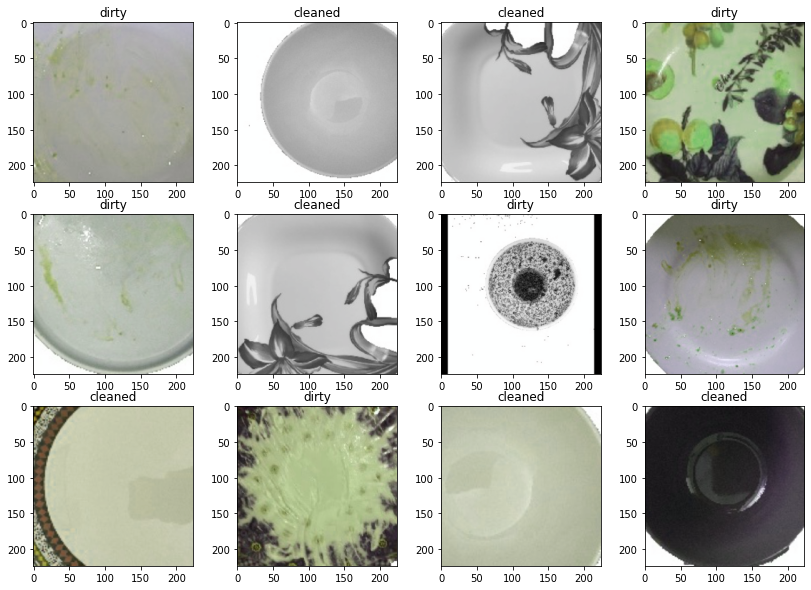

In [95]:

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)

image_iter = iter(train_dataloader)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for i in range(3):
    X_batch, y_batch = next(image_iter)
    for j in range(0, len(X_batch)):
        plt.subplot(3, 4, i*batch_size + j + 1)
        plt.title(class_names[y_batch[j].item()])
        plt.imshow(X_batch[j].permute(1, 2, 0).numpy() * std + mean)

  

# **Create models**

## Several models for training that can be used

In [96]:
class resNet50(torch.nn.Module):
    def __init__(self):
        super(resNet50, self).__init__()
        self.net = models.resnet50(pretrained=True)
        
        # Disable grad for all conv layers
        for param in self.net.parameters():
            param.requires_grad = False                
        
        # Create some additional layers for ResNet model
        fc_inputs = self.net.fc.in_features
        self.net.fc = torch.nn.Sequential(
            torch.nn.Linear(fc_inputs, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 2),
            # torch.nn.LogSoftmax(dim=1) # For using NLLLoss()
        )  
    def forward(self, x):
        x = self.net(x)
        return x

## Model Training Algorithm

In [97]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss_hist = {'train':[], 'valid':[]}
    accuracy_hist = {'train':[], 'valid':[]}
    
    print('{:<7s}|{:^20s}|{:^20s}|'.format('', 'Train', 'Valid'))
    print('{:<7s}|{:>10s}{:>10s}|{:>10s}{:>10s}|'.format('Epoch', 'Loss', 'Acc', 'Loss', 'Acc'))
    print('-' * 50)
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = valid_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss_value.item()
                # Running_acc += (preds_class == labels.data).float().mean()
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()                


            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                print('{:>3d}/{:>3d}|{:>10.4f}{:>10.4f}|'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc), end='')
            else:
                print('{:>10.4f}{:>10.4f}|'.format(epoch_loss, epoch_acc))

            loss_hist[phase].append(epoch_loss)
            accuracy_hist[phase].append(epoch_acc)

    return model, loss_hist, accuracy_hist

## Model traning function

In [98]:
def train_MyModel(model, epoch_num):
    print('\n' + model.__class__.__name__ + ' training with {} epochs started...\n'.format(epoch_num))
 
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model, losses, accuracies = train_model(model, loss, optimizer, scheduler, num_epochs=epoch_num);
    print('\nModel training finished.')    
    
    return model, losses, accuracies


# **Trainig**

## Run traning
Ok! We are ready for Model Training!
Choose one of them and start

In [99]:
import random
seed = 40
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

model = resNet50()

# Run model training
model, losses, accuracies = train_MyModel(model, epoch_num=40)

# Switch model to prediction mode
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



resNet50 training with 40 epochs started...

       |       Train        |       Valid        |
Epoch  |      Loss       Acc|      Loss       Acc|
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  1/ 40|    0.7534    0.4848|    0.6950    0.5000|
  2/ 40|    0.6962    0.5530|    0.6569    0.7857|
  3/ 40|    0.6632    0.6439|    0.5747    0.7500|
  4/ 40|    0.5374    0.7803|    0.4709    0.7143|
  5/ 40|    0.5513    0.7121|    0.4136    0.8214|
  6/ 40|    0.5753    0.6970|    0.4144    0.7857|
  7/ 40|    0.4428    0.8258|    0.3590    0.9286|
  8/ 40|    0.4178    0.8409|    0.3576    0.8214|
  9/ 40|    0.4547    0.7652|    0.4037    0.8214|
 10/ 40|    0.4035    0.8409|    0.2947    0.9286|
 11/ 40|    0.4136    0.7803|    0.3251    0.8929|
 12/ 40|    0.3642    0.8788|    0.3880    0.7143|
 13/ 40|    0.3880    0.8258|    0.3656    0.8571|
 14/ 40|    0.3414    0.8712|    0.3296    0.8929|
 15/ 40|    0.3743    0.8182|    0.3125    0.8929|
 16/ 40|    0.3789    0.8333|    0.3462    0.8571|
 17/ 40|    0.3339    0.8712|    0.3579    0.8929|
 18/ 40|    0.3616    0.8485|    0.2861    0.9286|
 19/ 40|    0.3702    0.8485|    0.3814    0.7857|
 20/ 40|    0.4355    0.8030|  

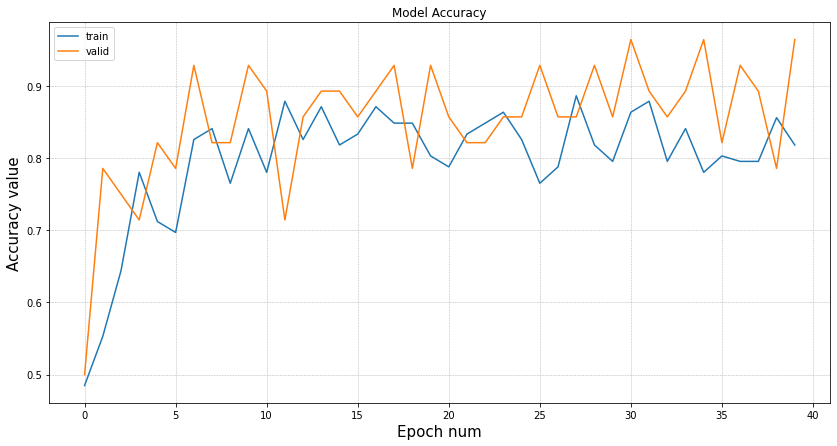

In [100]:

# Model accuracies visualization
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')


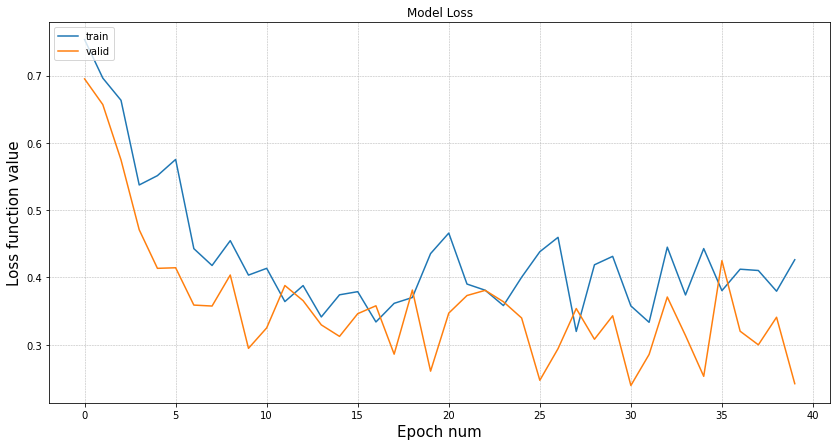

In [101]:

# Model loss-function visualization
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')


# **Prediction**

## Create a Test transformation methods
Now we are ready for predictions


In [102]:
  transform_image = {
    'to_tensor_and_normalize': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# List of transformation methods
transforms_list = { 
    'original': transforms.Compose([
        transforms.Resize((224, 224)),
    ]),   
#     'crop_220': transforms.Compose([
#         transforms.CenterCrop(220),
#         transforms.Resize((224, 224)),
#     ]), 
#     'crop_200': transforms.Compose([
#         transforms.CenterCrop(200),
#         transforms.Resize((224, 224)),
#     ]),    
    'crop_180': transforms.Compose([
        transforms.CenterCrop(180),
        transforms.Resize((224, 224)),
    ]),    
    'crop_160': transforms.Compose([
        transforms.CenterCrop(160),
        transforms.Resize((224, 224)),
    ]),   
    'crop_140': transforms.Compose([
        transforms.CenterCrop(140),
        transforms.Resize((224, 224)),
    ]),   
#     'crop_120': transforms.Compose([
#         transforms.CenterCrop(120),
#         transforms.Resize((224, 224)),
#     ]),    
    'gray_280': transforms.Compose([
        transforms.Grayscale(3),
        transforms.CenterCrop(280),
        transforms.Resize((224, 224)),
    ]),
    'gray_200': transforms.Compose([
        transforms.Grayscale(3),
        transforms.CenterCrop(200),
        transforms.Resize((224, 224)),
    ]),
    'r_crop_180_1': transforms.Compose([
        transforms.RandomCrop(180),
        transforms.Resize((224, 224)),
    ]),
    'r_crop_180_2': transforms.Compose([
        transforms.RandomCrop(180),
        transforms.Resize((224, 224)),
    ]),
    'r_crop_180_3': transforms.Compose([
        transforms.Grayscale(3),
        transforms.RandomCrop(180),
        transforms.Resize((224, 224)),
    ]),        
}

# Test Dataset
dataset['test'] = ImageFolderWithPaths('/content/test', transform=None)

# Test Dataloaders
test_dataloader  = torch.utils.data.DataLoader(dataset['test'],
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

## Let's predict the status for one chosen plate

N  Method         Percent
-------------------------
1  original        0.3748
2  crop_180        0.9027
3  crop_160        0.9293
4  crop_140        0.9232
5  gray_280        0.7578
6  gray_200        0.8989
7  r_crop_180_1    0.8992
8  r_crop_180_2    0.9192
9  r_crop_180_3    0.8726
-------------------------


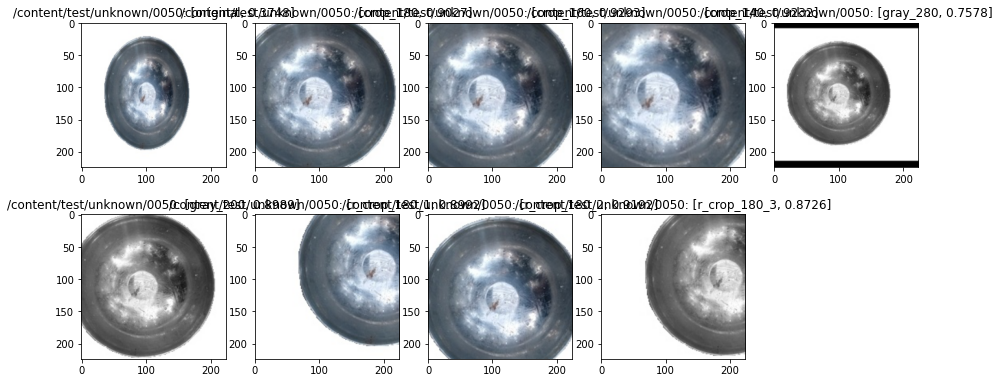

In [103]:
img_id = 50

img_original = test_dataloader.dataset[img_id][0]

img_id = test_dataloader.dataset[img_id][2]
img_id = img_id.replace('/content/working/test/unknown/', '')
img_id = img_id.replace('.jpg', '')

labels = {}
labels['id'] = img_id

# Make prediction for each method in tranformation_list
for i, method in enumerate(transforms_list):
    img_transformed = transforms_list[method](img_original)
    tensor = transform_image['to_tensor_and_normalize'](img_transformed)
    tensor = tensor.to(device)
    tensor = tensor.unsqueeze(0)

    with torch.set_grad_enabled(False):
        preds = model(tensor)
        
    label = torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()[0]
    labels[method] = label

# Vizualization 
plt.rcParams['figure.figsize'] = (15, 10)
for i, method in enumerate(transforms_list):
    img_transformed = transforms_list[method](img_original)
    plt.subplot(3, 5, i + 1)
    plt.title(img_id +': ['+ method + ', ' + str(round(labels[method],4))+']')
    plt.imshow(img_transformed); 

# Print prediction's results    
print('{:3s}{:15s}{:7s}'.format('N', 'Method', 'Percent')), print('-' * 25)
for i, method in enumerate([x for x in labels if x != 'id']):
    print('{:<3d}{:<15s}{:>7.4f}'.format(i+1, method, labels[method]))
print('-' * 25)

## Make predictions for all plates

In [104]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

data = []
for img_original, labels, img_id in tqdm(test_dataloader.dataset):
    labels = {}
    labels['id'] = img_id
    probs = np.array([])

    for i, method in enumerate(transforms_list):
        img_transformed = transforms_list[method](img_original)
        tensor = transform_image['to_tensor_and_normalize'](img_transformed)
        tensor = tensor.to(device)
        tensor = tensor.unsqueeze(0)

        with torch.set_grad_enabled(False):
            preds = model(tensor)

        label = torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()[0]
        labels[method] = label

    data.append(labels)

100%|██████████| 744/744 [23:42<00:00,  1.91s/it]


# **Submission**

## Data preparation

In [105]:
# Create DataFrame
df = pd.DataFrame(data)

df['id'] = df['id'].str.replace('/content/test/unknown/', '')
df['id'] = df['id'].str.replace('.jpg', '')

df.set_index('id', inplace=True)
df.head()

<ipython-input-105-778f80b785fc>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['id'] = df['id'].str.replace('.jpg', '')


,original,crop_180,crop_160,crop_140,gray_280,gray_200,r_crop_180_1,r_crop_180_2,r_crop_180_3
id,,,,,,,,,
0000,0.851793,0.917379,0.907823,0.918846,0.864338,0.915956,0.919611,0.891265,0.895270
0001,0.825629,0.889010,0.884943,0.859968,0.425698,0.806737,0.900890,0.914926,0.854957
0002,0.745580,0.461238,0.364184,0.182031,0.592694,0.528714,0.705814,0.714892,0.230903
0003,0.790707,0.932061,0.941042,0.930853,0.909148,0.893829,0.914764,0.924662,0.662183
0004,0.496997,0.914875,0.882838,0.885444,0.732498,0.851492,0.890101,0.899368,0.835072


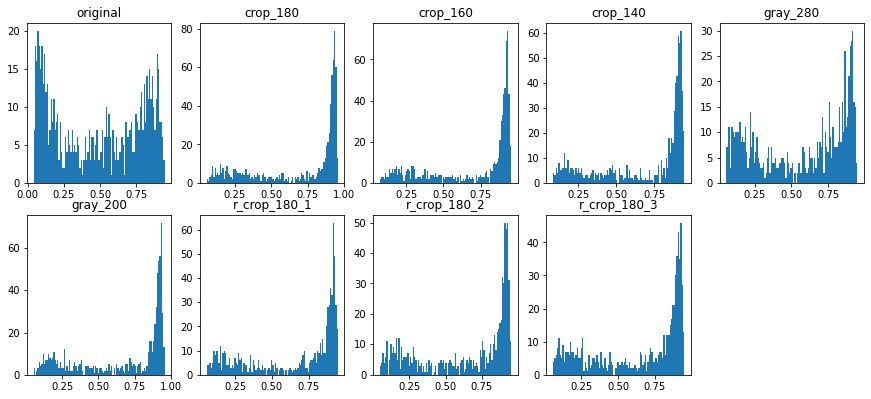

In [106]:
# Probability distribution visualization
plt.rcParams['figure.figsize'] = (15, 10)
for i, col_name in enumerate(df.columns):
    plt.subplot(3, 5, i + 1)
    plt.title(col_name)
    plt.hist(x=[df[col_name]], bins=100, histtype='bar');


In [107]:
# Data is skewed.So let's make some modifications to fix it
df['original'] = df['original']**(0.6)
# df['crop_220'] = df['crop_220']**(2.0)
# df['crop_200'] = df['crop_200']**(2.0)
df['crop_180'] = df['crop_180']**(2.5)
df['crop_160'] = df['crop_160']**(2.5)
df['crop_140'] = df['crop_140']**(2.5)
# df['crop_120'] = df['crop_120']**(2.0)
df['gray_280'] = df['gray_280']**(2.0)
df['gray_200'] = df['gray_200']**(2.5)
df['r_crop_180_1'] = df['r_crop_180_1']**(2.0)
df['r_crop_180_2'] = df['r_crop_180_2']**(2.0)
df['r_crop_180_3'] = df['r_crop_180_3']**(2.0)

In [108]:
# And a middle of each prediction method to zero
for col_name in df.columns:
    gap = 0.05
    plates_min = 999

    # Serch a middle between 0.4 and 0.7
    for i in range(40, 70):
        plates_num = df[(df[col_name] > i/100) & (df[col_name] < i/100 + gap)][col_name].count()
        if plates_min > plates_num:
            plates_min = plates_num
            middle = i/100

    # Shift a middle to zero
    df[col_name] = df[col_name] - middle + gap/2

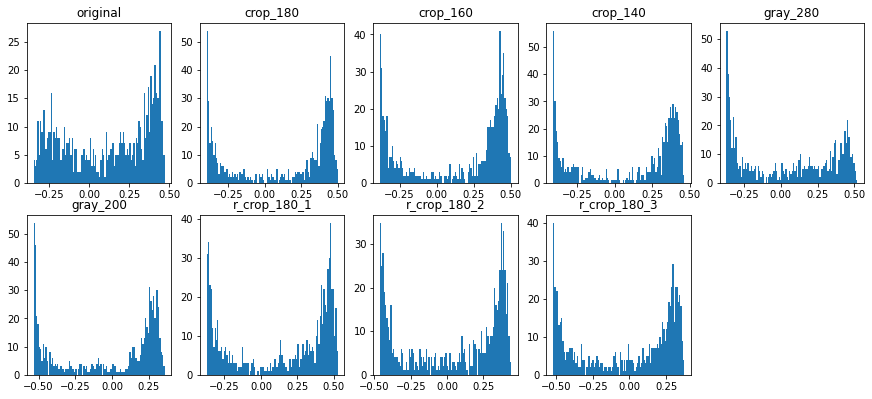

In [109]:
# Let's see what we've got
plt.rcParams['figure.figsize'] = (15, 10)
for i, col_name in enumerate(df.columns):
    plt.subplot(3, 5, i + 1)
    plt.title(col_name)
    plt.hist(x=[df[col_name]], bins=100, histtype='bar');

## Export submission file

In [110]:
# Prepare submission file
df['mean'] = df.mean(axis=1)
df['label'] = df['mean'].map(lambda x: 'cleaned' if x < 0 else 'dirty')
df.head()

,original,crop_180,crop_160,crop_140,gray_280,gray_200,r_crop_180_1,r_crop_180_2,r_crop_180_3,mean,label
id,,,,,,,,,,,
0000,0.413240,0.411068,0.400241,0.394295,0.372081,0.267945,0.470684,0.329353,0.276509,0.370602,dirty
0001,0.396397,0.350189,0.351695,0.270812,-0.193781,0.049561,0.436603,0.372089,0.205952,0.248835,dirty
0002,0.343487,-0.250518,-0.304961,-0.400863,-0.023714,-0.331740,0.123173,0.046071,-0.471684,-0.141194,cleaned
0003,0.373579,0.443707,0.474058,0.420994,0.451550,0.220330,0.461792,0.390000,-0.086514,0.349944,dirty
0004,0.162374,0.405579,0.347323,0.322740,0.161553,0.134040,0.417280,0.343863,0.172345,0.274122,dirty


In [111]:
# Remove extra columns
df.drop(df.columns[:-1], axis='columns', inplace=True)
df.head()

,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty


In [112]:
! rm -rf submission.csv

In [113]:
# Export predictions to *.csv file
# file_name = 'submission_' + model.__class__.__name__ + '.csv'
file_name = "resNet50_Seed" + str(seed)
df.to_csv(file_name)

In [114]:
#!rm -rf train valid test plates working plates.zip